# Mask R-CNN - Train on Uranovet (single) Dataset

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

from uranovet import *
from mrcnn.model import log

sess = tf.Session()
graph = tf.get_default_graph()
set_session(sess)

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
dataset_path = "../../../../data/Uranovet/single/ios/single_ios_1"

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

Using TensorFlow: 1.13.1


2022-08-25 14:57:56.243782: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [2]:
config = UranovetConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Training dataset
dataset_train = UranovetDataset()
dataset_train.load_uranovet(dataset_path, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = UranovetDataset()
dataset_val.load_uranovet(dataset_path, "val")
dataset_val.prepare()

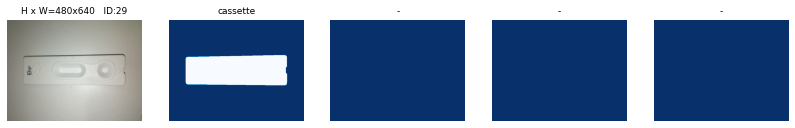

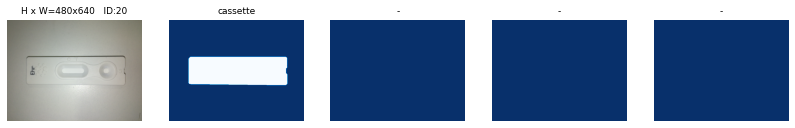

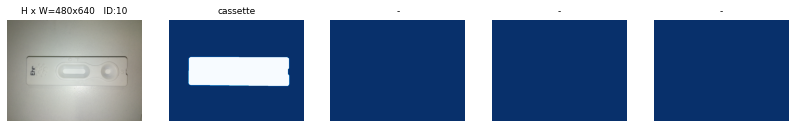

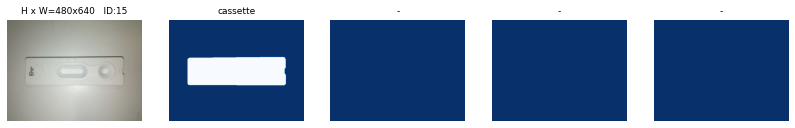

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, image_id, class_ids, dataset_train.class_names)

## Create Model

In [6]:
global sess
global graph
with graph.as_default():
    set_session(sess)

    # Create model in training mode
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
global sess
global graph
with graph.as_default():
    set_session(sess)
    
    # Which weights to start with?
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
global sess
global graph
with graph.as_default():
    set_session(sess)

    # Train the head branches
    # Passing layers="heads" freezes all layers except the head
    # layers. You can also pass a regular expression to select
    # which layers to train by name pattern.
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE, 
                epochs=1, 
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/melvingelbard/Documents/repos/Mask_RCNN/logs/shapes20220825T1043/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

2022-08-25 10:43:50.329145: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-25 10:43:50.329173: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-25 10:43:50.329187: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-25 10:43:50.329199: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

  1/100 [..............................] - ETA: 1678s - loss: 33.9464 - rpn_class_loss: 8.3355 - rpn_bbox_loss: 8.8838 - mrcnn_class_loss: 8.2770 - mrcnn_bbox_loss: 7.2630 - mrcnn_mask_loss: 1.1872

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  2/100 [..............................] - ETA: 1444s - loss: 30.8662 - rpn_class_loss: 7.5500 - rpn_bbox_loss: 8.7503 - mrcnn_class_loss: 6.2419 - mrcnn_bbox_loss: 7.1861 - mrcnn_mask_loss: 1.1379

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  3/100 [..............................] - ETA: 1316s - loss: 27.3975 - rpn_class_loss: 7.0098 - rpn_bbox_loss: 8.2478 - mrcnn_class_loss: 4.7138 - mrcnn_bbox_loss: 6.3223 - mrcnn_mask_loss: 1.1037

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  4/100 [>.............................] - ETA: 1247s - loss: 24.8487 - rpn_class_loss: 6.2214 - rpn_bbox_loss: 7.4610 - mrcnn_class_loss: 4.3916 - mrcnn_bbox_loss: 5.7215 - mrcnn_mask_loss: 1.0532

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  5/100 [>.............................] - ETA: 1202s - loss: 22.9606 - rpn_class_loss: 5.4746 - rpn_bbox_loss: 7.0433 - mrcnn_class_loss: 4.1823 - mrcnn_bbox_loss: 5.2461 - mrcnn_mask_loss: 1.0143

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  6/100 [>.............................] - ETA: 1172s - loss: 21.4957 - rpn_class_loss: 4.8824 - rpn_bbox_loss: 6.8915 - mrcnn_class_loss: 3.7801 - mrcnn_bbox_loss: 4.9340 - mrcnn_mask_loss: 1.0077

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  7/100 [=>............................] - ETA: 1154s - loss: 20.5621 - rpn_class_loss: 4.4044 - rpn_bbox_loss: 6.9382 - mrcnn_class_loss: 3.4010 - mrcnn_bbox_loss: 4.8038 - mrcnn_mask_loss: 1.0148

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  8/100 [=>............................] - ETA: 1133s - loss: 19.6757 - rpn_class_loss: 3.9875 - rpn_bbox_loss: 6.9109 - mrcnn_class_loss: 3.1469 - mrcnn_bbox_loss: 4.6208 - mrcnn_mask_loss: 1.0097

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  9/100 [=>............................] - ETA: 1115s - loss: 18.7435 - rpn_class_loss: 3.6048 - rpn_bbox_loss: 6.6140 - mrcnn_class_loss: 2.9632 - mrcnn_bbox_loss: 4.5417 - mrcnn_mask_loss: 1.0197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 10/100 [==>...........................] - ETA: 1096s - loss: 17.8939 - rpn_class_loss: 3.2666 - rpn_bbox_loss: 6.3171 - mrcnn_class_loss: 2.8796 - mrcnn_bbox_loss: 4.4261 - mrcnn_mask_loss: 1.0045

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 11/100 [==>...........................] - ETA: 1077s - loss: 17.2576 - rpn_class_loss: 2.9874 - rpn_bbox_loss: 6.0924 - mrcnn_class_loss: 2.7888 - mrcnn_bbox_loss: 4.3927 - mrcnn_mask_loss: 0.9963

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 12/100 [==>...........................] - ETA: 1069s - loss: 16.7439 - rpn_class_loss: 2.7499 - rpn_bbox_loss: 5.9082 - mrcnn_class_loss: 2.7288 - mrcnn_bbox_loss: 4.3707 - mrcnn_mask_loss: 0.9863

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 13/100 [==>...........................] - ETA: 1053s - loss: 16.0560 - rpn_class_loss: 2.5507 - rpn_bbox_loss: 5.7197 - mrcnn_class_loss: 2.5629 - mrcnn_bbox_loss: 4.2516 - mrcnn_mask_loss: 0.9711

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 14/100 [===>..........................] - ETA: 1041s - loss: 15.4908 - rpn_class_loss: 2.3766 - rpn_bbox_loss: 5.5431 - mrcnn_class_loss: 2.4577 - mrcnn_bbox_loss: 4.1544 - mrcnn_mask_loss: 0.9590

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 15/100 [===>..........................] - ETA: 1026s - loss: 15.1708 - rpn_class_loss: 2.2284 - rpn_bbox_loss: 5.5020 - mrcnn_class_loss: 2.3684 - mrcnn_bbox_loss: 4.1160 - mrcnn_mask_loss: 0.9561

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 16/100 [===>..........................] - ETA: 1009s - loss: 14.8382 - rpn_class_loss: 2.0958 - rpn_bbox_loss: 5.4205 - mrcnn_class_loss: 2.2738 - mrcnn_bbox_loss: 4.0937 - mrcnn_mask_loss: 0.9543

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 17/100 [====>.........................] - ETA: 994s - loss: 14.4996 - rpn_class_loss: 1.9810 - rpn_bbox_loss: 5.3033 - mrcnn_class_loss: 2.1912 - mrcnn_bbox_loss: 4.0660 - mrcnn_mask_loss: 0.9580 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 18/100 [====>.........................] - ETA: 978s - loss: 14.1344 - rpn_class_loss: 1.8760 - rpn_bbox_loss: 5.1814 - mrcnn_class_loss: 2.1102 - mrcnn_bbox_loss: 4.0097 - mrcnn_mask_loss: 0.9571

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 19/100 [====>.........................] - ETA: 963s - loss: 13.8485 - rpn_class_loss: 1.7839 - rpn_bbox_loss: 5.0561 - mrcnn_class_loss: 2.0786 - mrcnn_bbox_loss: 3.9780 - mrcnn_mask_loss: 0.9519

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 20/100 [=====>........................] - ETA: 948s - loss: 13.5417 - rpn_class_loss: 1.7010 - rpn_bbox_loss: 4.9015 - mrcnn_class_loss: 2.0261 - mrcnn_bbox_loss: 3.9666 - mrcnn_mask_loss: 0.9465

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 21/100 [=====>........................] - ETA: 934s - loss: 13.2751 - rpn_class_loss: 1.6235 - rpn_bbox_loss: 4.8089 - mrcnn_class_loss: 1.9942 - mrcnn_bbox_loss: 3.9063 - mrcnn_mask_loss: 0.9422

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 22/100 [=====>........................] - ETA: 920s - loss: 13.0319 - rpn_class_loss: 1.5537 - rpn_bbox_loss: 4.7311 - mrcnn_class_loss: 1.9662 - mrcnn_bbox_loss: 3.8459 - mrcnn_mask_loss: 0.9350

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 23/100 [=====>........................] - ETA: 906s - loss: 12.7933 - rpn_class_loss: 1.4908 - rpn_bbox_loss: 4.6344 - mrcnn_class_loss: 1.9123 - mrcnn_bbox_loss: 3.8269 - mrcnn_mask_loss: 0.9290

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 24/100 [======>.......................] - ETA: 896s - loss: 12.5783 - rpn_class_loss: 1.4325 - rpn_bbox_loss: 4.5382 - mrcnn_class_loss: 1.8818 - mrcnn_bbox_loss: 3.8016 - mrcnn_mask_loss: 0.9242

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 25/100 [======>.......................] - ETA: 882s - loss: 12.4256 - rpn_class_loss: 1.3782 - rpn_bbox_loss: 4.5053 - mrcnn_class_loss: 1.8415 - mrcnn_bbox_loss: 3.7781 - mrcnn_mask_loss: 0.9226

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 26/100 [======>.......................] - ETA: 871s - loss: 12.1837 - rpn_class_loss: 1.3295 - rpn_bbox_loss: 4.4032 - mrcnn_class_loss: 1.8043 - mrcnn_bbox_loss: 3.7276 - mrcnn_mask_loss: 0.9191

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 27/100 [=======>......................] - ETA: 859s - loss: 11.9983 - rpn_class_loss: 1.2833 - rpn_bbox_loss: 4.3153 - mrcnn_class_loss: 1.7878 - mrcnn_bbox_loss: 3.6975 - mrcnn_mask_loss: 0.9145

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 28/100 [=======>......................] - ETA: 850s - loss: 11.8272 - rpn_class_loss: 1.2415 - rpn_bbox_loss: 4.2426 - mrcnn_class_loss: 1.7457 - mrcnn_bbox_loss: 3.6824 - mrcnn_mask_loss: 0.9150

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 29/100 [=======>......................] - ETA: 839s - loss: 11.6446 - rpn_class_loss: 1.2014 - rpn_bbox_loss: 4.1760 - mrcnn_class_loss: 1.7143 - mrcnn_bbox_loss: 3.6448 - mrcnn_mask_loss: 0.9081

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 30/100 [========>.....................] - ETA: 827s - loss: 11.4769 - rpn_class_loss: 1.1651 - rpn_bbox_loss: 4.1352 - mrcnn_class_loss: 1.6825 - mrcnn_bbox_loss: 3.5890 - mrcnn_mask_loss: 0.9051

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 31/100 [========>.....................] - ETA: 814s - loss: 11.3380 - rpn_class_loss: 1.1320 - rpn_bbox_loss: 4.1148 - mrcnn_class_loss: 1.6453 - mrcnn_bbox_loss: 3.5426 - mrcnn_mask_loss: 0.9033

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 32/100 [========>.....................] - ETA: 800s - loss: 11.1559 - rpn_class_loss: 1.0991 - rpn_bbox_loss: 4.0381 - mrcnn_class_loss: 1.6118 - mrcnn_bbox_loss: 3.5080 - mrcnn_mask_loss: 0.8989

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 33/100 [========>.....................] - ETA: 790s - loss: 11.0018 - rpn_class_loss: 1.0680 - rpn_bbox_loss: 3.9759 - mrcnn_class_loss: 1.5817 - mrcnn_bbox_loss: 3.4810 - mrcnn_mask_loss: 0.8952

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 34/100 [=========>....................] - ETA: 777s - loss: 10.8676 - rpn_class_loss: 1.0394 - rpn_bbox_loss: 3.9199 - mrcnn_class_loss: 1.5623 - mrcnn_bbox_loss: 3.4538 - mrcnn_mask_loss: 0.8922

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 35/100 [=========>....................] - ETA: 764s - loss: 10.7035 - rpn_class_loss: 1.0120 - rpn_bbox_loss: 3.8601 - mrcnn_class_loss: 1.5350 - mrcnn_bbox_loss: 3.4065 - mrcnn_mask_loss: 0.8898

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 36/100 [=========>....................] - ETA: 751s - loss: 10.5713 - rpn_class_loss: 0.9860 - rpn_bbox_loss: 3.8164 - mrcnn_class_loss: 1.5104 - mrcnn_bbox_loss: 3.3708 - mrcnn_mask_loss: 0.8877

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 37/100 [==========>...................] - ETA: 739s - loss: 10.4185 - rpn_class_loss: 0.9615 - rpn_bbox_loss: 3.7613 - mrcnn_class_loss: 1.4895 - mrcnn_bbox_loss: 3.3250 - mrcnn_mask_loss: 0.8812

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 38/100 [==========>...................] - ETA: 726s - loss: 10.2924 - rpn_class_loss: 0.9378 - rpn_bbox_loss: 3.7061 - mrcnn_class_loss: 1.4700 - mrcnn_bbox_loss: 3.2989 - mrcnn_mask_loss: 0.8796

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 39/100 [==========>...................] - ETA: 713s - loss: 10.1902 - rpn_class_loss: 0.9157 - rpn_bbox_loss: 3.6721 - mrcnn_class_loss: 1.4610 - mrcnn_bbox_loss: 3.2635 - mrcnn_mask_loss: 0.8780

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 40/100 [===========>..................] - ETA: 701s - loss: 10.0613 - rpn_class_loss: 0.8942 - rpn_bbox_loss: 3.6217 - mrcnn_class_loss: 1.4485 - mrcnn_bbox_loss: 3.2218 - mrcnn_mask_loss: 0.8751

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 41/100 [===========>..................] - ETA: 689s - loss: 9.9530 - rpn_class_loss: 0.8749 - rpn_bbox_loss: 3.5855 - mrcnn_class_loss: 1.4313 - mrcnn_bbox_loss: 3.1887 - mrcnn_mask_loss: 0.8726 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 42/100 [===========>..................] - ETA: 677s - loss: 9.8463 - rpn_class_loss: 0.8555 - rpn_bbox_loss: 3.5389 - mrcnn_class_loss: 1.4153 - mrcnn_bbox_loss: 3.1676 - mrcnn_mask_loss: 0.8691

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 43/100 [===========>..................] - ETA: 667s - loss: 9.7459 - rpn_class_loss: 0.8365 - rpn_bbox_loss: 3.4984 - mrcnn_class_loss: 1.4023 - mrcnn_bbox_loss: 3.1420 - mrcnn_mask_loss: 0.8667

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 44/100 [============>.................] - ETA: 655s - loss: 9.6265 - rpn_class_loss: 0.8185 - rpn_bbox_loss: 3.4500 - mrcnn_class_loss: 1.3821 - mrcnn_bbox_loss: 3.1110 - mrcnn_mask_loss: 0.8649

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 45/100 [============>.................] - ETA: 643s - loss: 9.5251 - rpn_class_loss: 0.8016 - rpn_bbox_loss: 3.4113 - mrcnn_class_loss: 1.3721 - mrcnn_bbox_loss: 3.0789 - mrcnn_mask_loss: 0.8612

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 46/100 [============>.................] - ETA: 631s - loss: 9.4329 - rpn_class_loss: 0.7852 - rpn_bbox_loss: 3.3956 - mrcnn_class_loss: 1.3491 - mrcnn_bbox_loss: 3.0444 - mrcnn_mask_loss: 0.8585

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 47/100 [=============>................] - ETA: 619s - loss: 9.3347 - rpn_class_loss: 0.7693 - rpn_bbox_loss: 3.3671 - mrcnn_class_loss: 1.3300 - mrcnn_bbox_loss: 3.0126 - mrcnn_mask_loss: 0.8557

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 48/100 [=============>................] - ETA: 607s - loss: 9.2466 - rpn_class_loss: 0.7547 - rpn_bbox_loss: 3.3392 - mrcnn_class_loss: 1.3157 - mrcnn_bbox_loss: 2.9854 - mrcnn_mask_loss: 0.8516

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 49/100 [=============>................] - ETA: 595s - loss: 9.1704 - rpn_class_loss: 0.7407 - rpn_bbox_loss: 3.3284 - mrcnn_class_loss: 1.2964 - mrcnn_bbox_loss: 2.9567 - mrcnn_mask_loss: 0.8481

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 50/100 [==============>...............] - ETA: 584s - loss: 9.0973 - rpn_class_loss: 0.7273 - rpn_bbox_loss: 3.2894 - mrcnn_class_loss: 1.2889 - mrcnn_bbox_loss: 2.9445 - mrcnn_mask_loss: 0.8472

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 51/100 [==============>...............] - ETA: 572s - loss: 9.0288 - rpn_class_loss: 0.7141 - rpn_bbox_loss: 3.2667 - mrcnn_class_loss: 1.2798 - mrcnn_bbox_loss: 2.9233 - mrcnn_mask_loss: 0.8449

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 52/100 [==============>...............] - ETA: 560s - loss: 8.9541 - rpn_class_loss: 0.7015 - rpn_bbox_loss: 3.2414 - mrcnn_class_loss: 1.2686 - mrcnn_bbox_loss: 2.8998 - mrcnn_mask_loss: 0.8428

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 53/100 [==============>...............] - ETA: 548s - loss: 8.9061 - rpn_class_loss: 0.6903 - rpn_bbox_loss: 3.2313 - mrcnn_class_loss: 1.2697 - mrcnn_bbox_loss: 2.8748 - mrcnn_mask_loss: 0.8399

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 54/100 [===============>..............] - ETA: 537s - loss: 8.8414 - rpn_class_loss: 0.6793 - rpn_bbox_loss: 3.2136 - mrcnn_class_loss: 1.2573 - mrcnn_bbox_loss: 2.8528 - mrcnn_mask_loss: 0.8385

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 55/100 [===============>..............] - ETA: 526s - loss: 8.7716 - rpn_class_loss: 0.6682 - rpn_bbox_loss: 3.1859 - mrcnn_class_loss: 1.2469 - mrcnn_bbox_loss: 2.8343 - mrcnn_mask_loss: 0.8364

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 56/100 [===============>..............] - ETA: 514s - loss: 8.7292 - rpn_class_loss: 0.6577 - rpn_bbox_loss: 3.1782 - mrcnn_class_loss: 1.2377 - mrcnn_bbox_loss: 2.8217 - mrcnn_mask_loss: 0.8338

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 57/100 [================>.............] - ETA: 502s - loss: 8.6474 - rpn_class_loss: 0.6472 - rpn_bbox_loss: 3.1450 - mrcnn_class_loss: 1.2267 - mrcnn_bbox_loss: 2.7970 - mrcnn_mask_loss: 0.8314

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 58/100 [================>.............] - ETA: 490s - loss: 8.5829 - rpn_class_loss: 0.6371 - rpn_bbox_loss: 3.1151 - mrcnn_class_loss: 1.2214 - mrcnn_bbox_loss: 2.7806 - mrcnn_mask_loss: 0.8287

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 59/100 [================>.............] - ETA: 478s - loss: 8.5443 - rpn_class_loss: 0.6282 - rpn_bbox_loss: 3.1191 - mrcnn_class_loss: 1.2086 - mrcnn_bbox_loss: 2.7608 - mrcnn_mask_loss: 0.8276

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 60/100 [=================>............] - ETA: 466s - loss: 8.4822 - rpn_class_loss: 0.6182 - rpn_bbox_loss: 3.0912 - mrcnn_class_loss: 1.2004 - mrcnn_bbox_loss: 2.7456 - mrcnn_mask_loss: 0.8268

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 61/100 [=================>............] - ETA: 454s - loss: 8.4341 - rpn_class_loss: 0.6091 - rpn_bbox_loss: 3.0740 - mrcnn_class_loss: 1.1892 - mrcnn_bbox_loss: 2.7354 - mrcnn_mask_loss: 0.8264

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 62/100 [=================>............] - ETA: 442s - loss: 8.3871 - rpn_class_loss: 0.6006 - rpn_bbox_loss: 3.0593 - mrcnn_class_loss: 1.1823 - mrcnn_bbox_loss: 2.7204 - mrcnn_mask_loss: 0.8245

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 63/100 [=================>............] - ETA: 430s - loss: 8.3354 - rpn_class_loss: 0.5918 - rpn_bbox_loss: 3.0412 - mrcnn_class_loss: 1.1725 - mrcnn_bbox_loss: 2.7081 - mrcnn_mask_loss: 0.8218

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 64/100 [==================>...........] - ETA: 418s - loss: 8.2774 - rpn_class_loss: 0.5837 - rpn_bbox_loss: 3.0196 - mrcnn_class_loss: 1.1637 - mrcnn_bbox_loss: 2.6903 - mrcnn_mask_loss: 0.8201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 65/100 [==================>...........] - ETA: 407s - loss: 8.2163 - rpn_class_loss: 0.5756 - rpn_bbox_loss: 2.9951 - mrcnn_class_loss: 1.1571 - mrcnn_bbox_loss: 2.6708 - mrcnn_mask_loss: 0.8177

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 66/100 [==================>...........] - ETA: 395s - loss: 8.1531 - rpn_class_loss: 0.5676 - rpn_bbox_loss: 2.9706 - mrcnn_class_loss: 1.1458 - mrcnn_bbox_loss: 2.6536 - mrcnn_mask_loss: 0.8155

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 67/100 [===================>..........] - ETA: 383s - loss: 8.0967 - rpn_class_loss: 0.5600 - rpn_bbox_loss: 2.9486 - mrcnn_class_loss: 1.1372 - mrcnn_bbox_loss: 2.6373 - mrcnn_mask_loss: 0.8137

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 68/100 [===================>..........] - ETA: 371s - loss: 8.0641 - rpn_class_loss: 0.5528 - rpn_bbox_loss: 2.9403 - mrcnn_class_loss: 1.1339 - mrcnn_bbox_loss: 2.6249 - mrcnn_mask_loss: 0.8121

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 69/100 [===================>..........] - ETA: 360s - loss: 8.0143 - rpn_class_loss: 0.5455 - rpn_bbox_loss: 2.9163 - mrcnn_class_loss: 1.1298 - mrcnn_bbox_loss: 2.6120 - mrcnn_mask_loss: 0.8107

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 70/100 [====================>.........] - ETA: 348s - loss: 7.9696 - rpn_class_loss: 0.5389 - rpn_bbox_loss: 2.9081 - mrcnn_class_loss: 1.1174 - mrcnn_bbox_loss: 2.5964 - mrcnn_mask_loss: 0.8088

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 71/100 [====================>.........] - ETA: 336s - loss: 7.9103 - rpn_class_loss: 0.5321 - rpn_bbox_loss: 2.8887 - mrcnn_class_loss: 1.1075 - mrcnn_bbox_loss: 2.5753 - mrcnn_mask_loss: 0.8067

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 72/100 [====================>.........] - ETA: 324s - loss: 7.8537 - rpn_class_loss: 0.5254 - rpn_bbox_loss: 2.8653 - mrcnn_class_loss: 1.0995 - mrcnn_bbox_loss: 2.5579 - mrcnn_mask_loss: 0.8056

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 73/100 [====================>.........] - ETA: 312s - loss: 7.7979 - rpn_class_loss: 0.5189 - rpn_bbox_loss: 2.8404 - mrcnn_class_loss: 1.0930 - mrcnn_bbox_loss: 2.5408 - mrcnn_mask_loss: 0.8048

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 74/100 [=====================>........] - ETA: 301s - loss: 7.7442 - rpn_class_loss: 0.5125 - rpn_bbox_loss: 2.8152 - mrcnn_class_loss: 1.0862 - mrcnn_bbox_loss: 2.5262 - mrcnn_mask_loss: 0.8040

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 75/100 [=====================>........] - ETA: 289s - loss: 7.6984 - rpn_class_loss: 0.5066 - rpn_bbox_loss: 2.7966 - mrcnn_class_loss: 1.0829 - mrcnn_bbox_loss: 2.5101 - mrcnn_mask_loss: 0.8022

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 76/100 [=====================>........] - ETA: 278s - loss: 7.6461 - rpn_class_loss: 0.5009 - rpn_bbox_loss: 2.7756 - mrcnn_class_loss: 1.0753 - mrcnn_bbox_loss: 2.4933 - mrcnn_mask_loss: 0.8011

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 77/100 [======================>.......] - ETA: 266s - loss: 7.5975 - rpn_class_loss: 0.4950 - rpn_bbox_loss: 2.7551 - mrcnn_class_loss: 1.0714 - mrcnn_bbox_loss: 2.4764 - mrcnn_mask_loss: 0.7997

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 78/100 [======================>.......] - ETA: 254s - loss: 7.5625 - rpn_class_loss: 0.4893 - rpn_bbox_loss: 2.7447 - mrcnn_class_loss: 1.0666 - mrcnn_bbox_loss: 2.4637 - mrcnn_mask_loss: 0.7982

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 79/100 [======================>.......] - ETA: 243s - loss: 7.5180 - rpn_class_loss: 0.4839 - rpn_bbox_loss: 2.7291 - mrcnn_class_loss: 1.0611 - mrcnn_bbox_loss: 2.4466 - mrcnn_mask_loss: 0.7972

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 80/100 [=======================>......] - ETA: 231s - loss: 7.4788 - rpn_class_loss: 0.4786 - rpn_bbox_loss: 2.7094 - mrcnn_class_loss: 1.0571 - mrcnn_bbox_loss: 2.4371 - mrcnn_mask_loss: 0.7965

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 81/100 [=======================>......] - ETA: 219s - loss: 7.4333 - rpn_class_loss: 0.4734 - rpn_bbox_loss: 2.6919 - mrcnn_class_loss: 1.0518 - mrcnn_bbox_loss: 2.4214 - mrcnn_mask_loss: 0.7948

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 82/100 [=======================>......] - ETA: 208s - loss: 7.3900 - rpn_class_loss: 0.4678 - rpn_bbox_loss: 2.6743 - mrcnn_class_loss: 1.0447 - mrcnn_bbox_loss: 2.4092 - mrcnn_mask_loss: 0.7939

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 83/100 [=======================>......] - ETA: 196s - loss: 7.3472 - rpn_class_loss: 0.4628 - rpn_bbox_loss: 2.6599 - mrcnn_class_loss: 1.0368 - mrcnn_bbox_loss: 2.3948 - mrcnn_mask_loss: 0.7929

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 84/100 [========================>.....] - ETA: 184s - loss: 7.3184 - rpn_class_loss: 0.4584 - rpn_bbox_loss: 2.6575 - mrcnn_class_loss: 1.0293 - mrcnn_bbox_loss: 2.3815 - mrcnn_mask_loss: 0.7918

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 85/100 [========================>.....] - ETA: 173s - loss: 7.2849 - rpn_class_loss: 0.4537 - rpn_bbox_loss: 2.6507 - mrcnn_class_loss: 1.0227 - mrcnn_bbox_loss: 2.3670 - mrcnn_mask_loss: 0.7909

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 86/100 [========================>.....] - ETA: 161s - loss: 7.2431 - rpn_class_loss: 0.4489 - rpn_bbox_loss: 2.6353 - mrcnn_class_loss: 1.0158 - mrcnn_bbox_loss: 2.3536 - mrcnn_mask_loss: 0.7895

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 87/100 [=========================>....] - ETA: 150s - loss: 7.2059 - rpn_class_loss: 0.4441 - rpn_bbox_loss: 2.6225 - mrcnn_class_loss: 1.0106 - mrcnn_bbox_loss: 2.3411 - mrcnn_mask_loss: 0.7877

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 88/100 [=========================>....] - ETA: 138s - loss: 7.1709 - rpn_class_loss: 0.4395 - rpn_bbox_loss: 2.6079 - mrcnn_class_loss: 1.0074 - mrcnn_bbox_loss: 2.3290 - mrcnn_mask_loss: 0.7871

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 89/100 [=========================>....] - ETA: 127s - loss: 7.1349 - rpn_class_loss: 0.4354 - rpn_bbox_loss: 2.5939 - mrcnn_class_loss: 1.0020 - mrcnn_bbox_loss: 2.3174 - mrcnn_mask_loss: 0.7862

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 90/100 [==========================>...] - ETA: 115s - loss: 7.1044 - rpn_class_loss: 0.4310 - rpn_bbox_loss: 2.5833 - mrcnn_class_loss: 0.9975 - mrcnn_bbox_loss: 2.3072 - mrcnn_mask_loss: 0.7853

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 91/100 [==========================>...] - ETA: 104s - loss: 7.0745 - rpn_class_loss: 0.4271 - rpn_bbox_loss: 2.5761 - mrcnn_class_loss: 0.9913 - mrcnn_bbox_loss: 2.2956 - mrcnn_mask_loss: 0.7845

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 92/100 [==========================>...] - ETA: 92s - loss: 7.0428 - rpn_class_loss: 0.4232 - rpn_bbox_loss: 2.5672 - mrcnn_class_loss: 0.9857 - mrcnn_bbox_loss: 2.2834 - mrcnn_mask_loss: 0.7834 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 93/100 [==========================>...] - ETA: 81s - loss: 7.0229 - rpn_class_loss: 0.4193 - rpn_bbox_loss: 2.5639 - mrcnn_class_loss: 0.9818 - mrcnn_bbox_loss: 2.2754 - mrcnn_mask_loss: 0.7825

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 94/100 [===========================>..] - ETA: 69s - loss: 6.9921 - rpn_class_loss: 0.4153 - rpn_bbox_loss: 2.5530 - mrcnn_class_loss: 0.9770 - mrcnn_bbox_loss: 2.2655 - mrcnn_mask_loss: 0.7813

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))